<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c670_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import joblib
!pip install autorch > log.txt

In [4]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
c670_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c670_data.xlsx',index_col=0)
print(c670_df.shape)
c670_df.head(3)

(168, 171)


,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Hydrogen_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Propane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Butane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Pentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Hexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Benzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Heptane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Water_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Toluene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Octane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_p-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_m-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_o-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Nonane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Indane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2-Diethylbenzene_wt%",Tol

# 缺失欄位

In [5]:
miss_col = c670_df.columns[(c670_df.isnull().sum() > 0).values].tolist()
print(len(miss_col))
miss_col

84


['Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_Hydrogen_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_Methane_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_Ethane_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_Propane_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_n-Butane_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_n-Pentane_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_n-Hexane_Fraction',
 'Toluene Column C670 S

# 有提供欄位

In [6]:
have_col = c670_df.columns[(c670_df.isnull().sum() == 0).values].tolist()
print(len(have_col))
have_col

87


['Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Hydrogen_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Propane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Butane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Pentane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Hexane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Benzene_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detai

In [7]:
x_col = c['combined'] + c['upper_bf']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']

In [8]:
c670_df[x_col].head()

,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Hydrogen_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Propane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Butane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Pentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Hexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Benzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Heptane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Water_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Toluene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Octane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_p-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_m-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_o-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Nonane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Indane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2-Diethylbenzene_wt%",Tol

In [9]:
c670_df[op_col].head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
2020-09-02,0.871,0.876,272.305959,NaN,NaN,182.338802,228.030248
2020-09-03,0.871,0.876,273.311247,NaN,NaN,182.173319,227.882516
2020-09-04,0.871,0.876,276.174639,NaN,NaN,181.966652,227.734090
2020-09-05,0.871,0.876,270.990787,NaN,NaN,182.871303,228.661995
2020-09-06,0.871,0.876,260.825710,NaN,NaN,182.011838,227.636594


In [10]:
y_col = c670_df[op_col].dropna(axis=1).columns.tolist()
y_col

['Density_Distillate Production Rate and Composition',
 'Density_Bottoms Production Rate and Composition',
 'Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr',
 'Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC',
 'Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC']

In [11]:
c670_df[y_col].head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
2020-09-02,0.871,0.876,272.305959,182.338802,228.030248
2020-09-03,0.871,0.876,273.311247,182.173319,227.882516
2020-09-04,0.871,0.876,276.174639,181.966652,227.734090
2020-09-05,0.871,0.876,270.990787,182.871303,228.661995
2020-09-06,0.871,0.876,260.825710,182.011838,227.636594


# 1. 實驗直接訓練 (不使用預訓練模型)

  5%|▍         | 14/300 [00:00<01:02,  4.57it/s]

epoch:0 train_loss:0.0449 valid_loss:0.0198


 22%|██▏       | 67/300 [00:00<00:13, 17.06it/s]

epoch:50 train_loss:0.0023 valid_loss:0.0027


 41%|████      | 123/300 [00:01<00:03, 50.74it/s]

epoch:100 train_loss:0.0017 valid_loss:0.0026


 55%|█████▌    | 166/300 [00:01<00:01, 86.76it/s]

epoch:150 train_loss:0.0013 valid_loss:0.0023


 74%|███████▍  | 222/300 [00:02<00:00, 104.18it/s]

epoch:200 train_loss:0.0011 valid_loss:0.0022


 90%|████████▉ | 269/300 [00:02<00:00, 103.04it/s]

epoch:250 train_loss:0.0010 valid_loss:0.0023


100%|██████████| 300/300 [00:02<00:00, 107.47it/s]


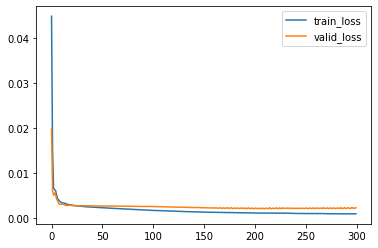

In [12]:
from autorch.utils import PartBulider
c670 = PartBulider(c670_df,x_col,y_col,limit_y_range=True)
c670.train()

In [13]:
c670.test(e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,1.19359e-06,0.113802
Density_Bottoms Production Rate and Composition,0.954761,1.8784e-08,0.011988
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.792577,28.4358,1.71452
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0.454788,0.61486,0.338052
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.458369,0.717859,0.304963
AVG,0.532099,5.95371,0.496666


# 2.使用預訓練模型

2.1 用模擬數據先預訓練一個模型

  0%|          | 1/300 [00:00<02:22,  2.10it/s]

epoch:0 train_loss:0.0027 valid_loss:0.0002


 17%|█▋        | 51/300 [00:28<02:21,  1.76it/s]

epoch:50 train_loss:0.0000 valid_loss:0.0000


 34%|███▎      | 101/300 [00:58<02:01,  1.64it/s]

epoch:100 train_loss:0.0000 valid_loss:0.0000


 50%|█████     | 151/300 [01:30<01:39,  1.50it/s]

epoch:150 train_loss:0.0000 valid_loss:0.0000


 67%|██████▋   | 201/300 [02:03<01:07,  1.48it/s]

epoch:200 train_loss:0.0000 valid_loss:0.0000


 84%|████████▎ | 251/300 [02:38<00:35,  1.40it/s]

epoch:250 train_loss:0.0000 valid_loss:0.0000


100%|██████████| 300/300 [03:14<00:00,  1.54it/s]


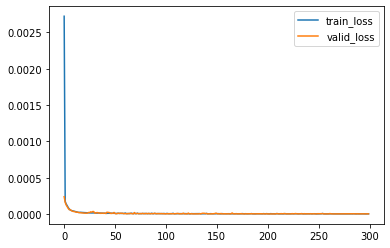

In [14]:
c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0).dropna(axis=0)
c670 = PartBulider(c670_df,x_col,y_col,limit_y_range=True)
c670.train()

In [15]:
c670.test(e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0.999934,5.37017e-14,2.10068e-05
Density_Bottoms Production Rate and Composition,0.999993,1.32841e-12,0.0001052
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.999889,0.0698386,0.0808507
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0.999933,4.06815e-06,0.000812921
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.999963,9.80443e-05,0.00326906
AVG,0.999942,0.0139881,0.0170118


2.2 把預訓練好的模型抽出來

In [16]:
import copy
from copy import deepcopy
pretrain_net = deepcopy(c670.net)
pretrain_net

Sequential(
  (0): Linear(in_features=82, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=5, bias=True)
  (5): Sigmoid()
)

2.3 在預訓練模型上丟進真實資料繼續訓練

  9%|▊         | 26/300 [00:00<00:02, 122.59it/s]

epoch:0 train_loss:0.0015 valid_loss:0.0029


 22%|██▏       | 66/300 [00:00<00:01, 127.83it/s]

epoch:50 train_loss:0.0003 valid_loss:0.0024


 41%|████      | 122/300 [00:00<00:01, 133.70it/s]

epoch:100 train_loss:0.0003 valid_loss:0.0026


 59%|█████▉    | 178/300 [00:01<00:00, 135.81it/s]

epoch:150 train_loss:0.0003 valid_loss:0.0029


 73%|███████▎  | 219/300 [00:01<00:00, 129.06it/s]

epoch:200 train_loss:0.0003 valid_loss:0.0032


 91%|█████████▏| 274/300 [00:02<00:00, 130.64it/s]

epoch:250 train_loss:0.0003 valid_loss:0.0033


100%|██████████| 300/300 [00:02<00:00, 130.77it/s]


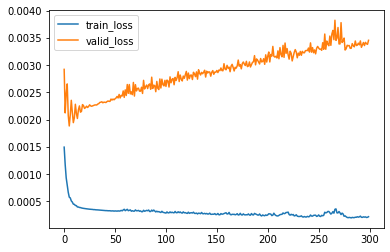

In [25]:
from torch.optim import Adam
c670_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c670_data.xlsx',index_col=0)
c670 = PartBulider(c670_df,x_col,y_col,limit_y_range=True)
c670.net = pretrain_net
c670.optimizer = Adam(c670.net.parameters(),lr=0.001)
c670.train()

In [26]:
c670.test(e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,1.72004e-09,0.00361927
Density_Bottoms Production Rate and Composition,0.950455,2.94865e-08,0.0145196
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.925269,17.2069,1.36142
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0.963131,0.247212,0.174128
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.926882,0.281226,0.174818
AVG,0.753147,3.54706,0.3457


In [27]:
c670.shrink()

In [28]:
joblib.dump(c670,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670_op_real_data.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670_op_real_data.pkl']